# Learning Distributed Computing

_Finding out the size of my data and testing how batch sizes affect run through_

<u> Results </u>
- On batch size 16, I could run through maybe 2 DFNN (through 50 epochs each) before I ran out of memory on my one NVIDIA AA100 GPU with 38334 MB memory (Now, this runs through all 3 models in one go).
- On batch size 32, I could run through I could run through all 3 DFNN.
- On batch size 64, I could run through 2 DFNN (stalls on the third). 
- On batch size 8, I could run through all 3 DFNN.
- On batch size 4, I could run through all 3 DFNN.

# 3.4 Deep Feedforward Neural Network (w/ GAN data)

## 1. Data Load In

In [1]:
import nibabel as nib
import numpy as np
import glob
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial
import PIL
import PIL.Image
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

np.random.seed(42) # note that you must use the same seed to ensure consistentcy in your training/validation/testing
tf.random.set_seed(42)

In [2]:
# cases + conrols df
df = pd.read_csv('/project/ds6050-soa2wg/team_lambda_II/ASD_DSM_CasesvsControls.csv', sep = ',')

# obtain paths for all images
images_paths_f_case = list(df.query("SEX_ == 'Female' & DX_Control == 'Autism'")['PATH'])
images_paths_f_control = list(df.query("SEX_ == 'Female' & DX_Control == 'Control'")['PATH'])
images_paths_m_case = list(df.query("SEX_ == 'Male' & DX_Control == 'Autism'")['PATH'])
images_paths_m_control = list(df.query("SEX_ == 'Male' & DX_Control == 'Control'")['PATH'])

# GAN
gan_data_m = np.load('4hr_gan_pos_female_ep500_cs3000_si50.npy')
gan_data_f = np.load('4hr_gan_pos_male_ep500_cs3000_si50.npy')

In [3]:
gan_data_m.shape

(50, 61, 73, 61)

In [4]:
gan_data_f.shape

(50, 61, 73, 61)

In [5]:
gan_data_cases = np.concatenate((gan_data_f, gan_data_m))

In [6]:
gan_data_cases.shape

(100, 61, 73, 61)

In [7]:
total_cases = len(images_paths_f_case) + len(images_paths_m_case) + gan_data_m.shape[0] + gan_data_f.shape[0]
total_controls = len(images_paths_f_control ) + len(images_paths_m_control) #+ gan_control_f.shape[0]
# print out number of participants per category
print('There are {} female cases'.format(str(len(images_paths_f_case) + gan_data_f.shape[0])))
print('---------------------------------------')
print('There are {} female controls'.format(str(len(images_paths_f_control))))
print('---------------------------------------')
print('There are {} male cases'.format(str(len(images_paths_m_case) + gan_data_m.shape[0])))
print('---------------------------------------')
print('There are {} male controls'.format(str(len(images_paths_m_control))))
print('---------------------------------------')
print(f'There are {total_cases} total cases and {total_controls} total controls! {total_controls + total_cases} participants in total')
# make one giant list
images_paths = images_paths_f_case  + images_paths_f_control + images_paths_m_case + images_paths_m_control

num_im = len(images_paths)
image_array = []

There are 72 female cases
---------------------------------------
There are 61 female controls
---------------------------------------
There are 174 male cases
---------------------------------------
There are 184 male controls
---------------------------------------
There are 246 total cases and 245 total controls! 491 participants in total


In [8]:
final_list = [] # create image array from paths
for path in images_paths:
    try: 
        img = nib.load(path)
        image_data = img.get_fdata()
        image_array.append(image_data)
        final_list.append(path)
    except:
        continue

image_array = np.asarray(image_array).astype('float32')
image_array = np.vstack((image_array,gan_data_cases))  

In [9]:
image_array.shape

(491, 61, 73, 61)

In [10]:
pheno = df[['FILE_ID', 'DX_GROUP']]
pheno_array = np.array(pheno['DX_GROUP'])
pheno_array = np.where(pheno_array == 2, 0, pheno_array) # 0 = control, 1 = dx
# distribution
df['DX_GROUP'].value_counts()

2    245
1    146
Name: DX_GROUP, dtype: int64

In [11]:
# gan_pheno
gan_pheno_cases = np.ones((gan_data_cases.shape[0],), dtype=int)
all_pheno = np.concatenate((pheno_array, gan_pheno_cases))

In [12]:
#training and holdout split
x_train, x_val, y_train, y_val = train_test_split(image_array, all_pheno, test_size = 0.15, random_state = 654)

#training and testing split
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.25, random_state = 654)

#### Find the memory size of a NumPy array

In [13]:
# Checking size (really, memory) of data
# quick and not necessarily throughly studied implementation: 
# https://www.geeksforgeeks.org/find-the-memory-size-of-a-numpy-array/#:~:text=So%20for%20finding%20the%20memory,of%20NumPy%20array%20in%20bytes.
# Method 1: Using size and itemsize attributes of NumPy array

#size: This attribute gives the number of elements present in the NumPy array.
#itemsize: This attribute gives the memory size of one element of NumPy array in bytes.

In [14]:
#import numpy as np 
# create a numpy 1d-array
x = image_array
  
print("Size of the array: ",
      x.size)
  
print("Memory size of one array element in bytes: ",
      x.itemsize)
  
# memory size of numpy array in bytes
print("Memory size of numpy array in bytes:",
      x.size * x.itemsize)

Size of the array:  133371803
Memory size of one array element in bytes:  4
Memory size of numpy array in bytes: 533487212


In [15]:
#import numpy as np 
# create a numpy 1d-array
x = all_pheno
  
print("Size of the array: ",
      x.size)
  
print("Memory size of one array element in bytes: ",
      x.itemsize)
  
# memory size of numpy array in bytes
print("Memory size of numpy array in bytes:",
      x.size * x.itemsize)

Size of the array:  491
Memory size of one array element in bytes:  8
Memory size of numpy array in bytes: 3928


In [16]:
#import numpy as np 
# create a numpy 1d-array
x = x_train
  
print("Size of the array: ",
      x.size)
  
print("Memory size of one array element in bytes: ",
      x.itemsize)
  
# memory size of numpy array in bytes
print("Memory size of numpy array in bytes:",
      x.size * x.itemsize)

Size of the array:  84749496
Memory size of one array element in bytes:  4
Memory size of numpy array in bytes: 338997984


In [17]:
# Method 2: Using nbytes attribute of NumPy array
#nbytes: This attribute gives the total bytes consumed by the elements of the NumPy array.

# import library
#import numpy as np
  
# create numpy 1d-array
x = image_array
  
print("Memory size of a NumPy array:",
      x.nbytes)

# 533,487,212 bytes is equivalent to 533 MB

Memory size of a NumPy array: 533487212


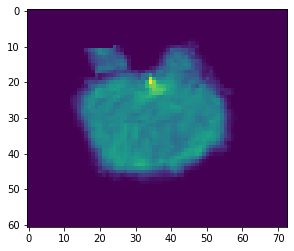

In [18]:
plt.imshow(x_train[15][48].T)

In [19]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test))

batch_size = 8
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
#     .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_test))
#    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

2022-05-06 18:38:54.593270: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-06 18:38:56.805647: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38334 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2022-05-06 18:38:56.811627: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38397 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:4e:00.0, compute capability: 8.0


#### Measuring Time to Run 

In [20]:
from timeit import default_timer as timer
start = timer()

## 2. Model

### 2.1 Highest performing DFNN architecture from Mellema 2022 ** Best Performing with GAN data **

In [21]:
def Dense_model(width=61, height=73, depth=61):
    """Build a Highest performing Dense FNN neural network model from Mellema 2022."""

    inputs = keras.Input((width, height, depth, 1))
    
    x = layers.Dense(6,kernel_regularizer=tf.keras.regularizers.l2(0.0001))(inputs)
    x = layers.Dense(units=64, activation="relu")(x)
    x = layers.Dropout(0.13)(x)
    x = layers.Dense(units=64, activation="relu")(x)
    x = layers.Flatten()(x)
    

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="DFNN")
    return model


# Build model.
model = Dense_model(width=61, height=73, depth=61)
model.summary()

Model: "DFNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 61, 73, 61, 1)]   0         
                                                                 
 dense (Dense)               (None, 61, 73, 61, 6)     12        
                                                                 
 dense_1 (Dense)             (None, 61, 73, 61, 64)    448       
                                                                 
 dropout (Dropout)           (None, 61, 73, 61, 64)    0         
                                                                 
 dense_2 (Dense)             (None, 61, 73, 61, 64)    4160      
                                                                 
 flatten (Flatten)           (None, 17384512)          0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1738451

In [22]:
# Compile model.
initial_learning_rate = 0.0001

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

# Compile model.
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.AUC()],
)

# Define callbacks.
#checkpoint_cb = keras.callbacks.ModelCheckpoint(
 #   "3d_image_classification_Cxa_DFNN.h5", save_best_only=True
#)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_binary_accuracy", patience=10)

# Train the model, doing validation at the end of each epoch
epochs = 125
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    callbacks=early_stopping_cb,
)

Epoch 1/125


2022-05-06 18:39:00.975254: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


39/39 [==============================] - 5s 49ms/step - loss: 37740.8828 - binary_accuracy: 0.5481 - auc: 0.5459 - val_loss: 15278.4189 - val_binary_accuracy: 0.5714 - val_auc: 0.5312
Epoch 2/125
39/39 [==============================] - 2s 42ms/step - loss: 13771.4043 - binary_accuracy: 0.6859 - auc: 0.6748 - val_loss: 3970.0881 - val_binary_accuracy: 0.7810 - val_auc: 0.7884
Epoch 3/125
39/39 [==============================] - 2s 42ms/step - loss: 5230.6616 - binary_accuracy: 0.7756 - auc: 0.7688 - val_loss: 16076.4805 - val_binary_accuracy: 0.6476 - val_auc: 0.6754
Epoch 4/125
39/39 [==============================] - 2s 42ms/step - loss: 5144.0679 - binary_accuracy: 0.7308 - auc: 0.7183 - val_loss: 5337.7002 - val_binary_accuracy: 0.7143 - val_auc: 0.7315
Epoch 5/125
39/39 [==============================] - 2s 42ms/step - loss: 2762.0237 - binary_accuracy: 0.7756 - auc: 0.7556 - val_loss: 2765.2783 - val_binary_accuracy: 0.8190 - val_auc: 0.8070
Epoch 6/125
39/39 [===================

In [23]:
# # Save the weights
# model.save_weights('DFNN_DoubleActuals_mod1.h5')

In [24]:
# # # Load best weights.
# model.load_weights("DFNN_DoubleActuals_mod1.h5")
prediction = model.predict(np.expand_dims(x_test[0], axis=0))[0]
print(prediction)
scores = [1 - prediction[0], prediction[0]]

class_names = ["normal", "abnormal"]
for score, name in zip(scores, class_names):
    print(
    "This model is %.2f percent confident that CT scan is %s"
    % ((100 * score), name))
print(y_test[0])

[0.]
This model is 100.00 percent confident that CT scan is normal
This model is 0.00 percent confident that CT scan is abnormal
0


In [25]:
#proportion of training data that's positive
sum(y_train) / len(y_train)

#proportion of holdout data that's positive
(sum(y_val) / len(y_val))

#evaluate on the holdout data
model.evaluate(x_val, y_val)

3/3 [==============================] - 0s 31ms/step - loss: 899.2334 - binary_accuracy: 0.7973 - auc: 0.7868


[899.2333984375, 0.7972972989082336, 0.7868131995201111]

In [26]:
from sklearn.metrics import classification_report, confusion_matrix

preds = model.predict(x_val)

preds = np.where(preds > .5, 1,0)



print(classification_report(y_val, preds))
cm = confusion_matrix(y_val, preds)

              precision    recall  f1-score   support

           0       0.73      0.91      0.81        35
           1       0.90      0.69      0.78        39

    accuracy                           0.80        74
   macro avg       0.81      0.80      0.80        74
weighted avg       0.82      0.80      0.80        74



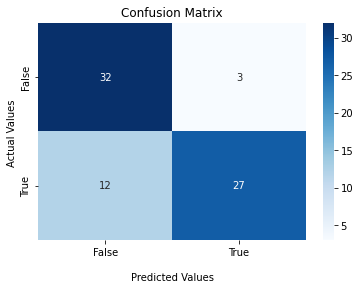

In [27]:
import seaborn as sns

ax = sns.heatmap(cm, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [28]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(x_val).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_val, y_pred_keras)

In [29]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

In [30]:
auc_keras

0.7985347985347985

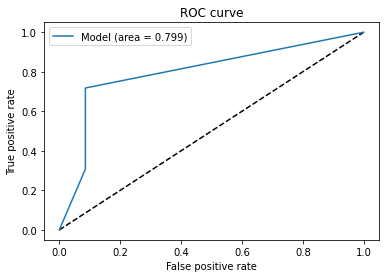

In [31]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Model (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [32]:
# from PIL import ImageFont
# font = ImageFont.truetype("Arial.ttf", 16)
# visualkeras.layered_view(model, legend=True,font = font, to_file='DFNN1arch_gan.png')  # font is optional!

### 2.2 Build a Highest performing Dense FNN neural network model from Mellema 2022 with modifications

In [33]:
def Dense_model(width=61, height=73, depth=61):
    """Build a Highest performing Dense FNN neural network model from Mellema 2022 with modifications."""

    inputs = keras.Input((width, height, depth, 1))  
     
    x = layers.Dense(6,kernel_regularizer=tf.keras.regularizers.l2(0.0001))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(units=128, activation="relu")(x)
    x = layers.Dropout(0.13)(x)
    x = layers.Dense(units=64, activation="relu")(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="DFNN")
    return model


# Build model.
model = Dense_model(width=61, height=73, depth=61)
model.summary()

Model: "DFNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 61, 73, 61, 1)]   0         
                                                                 
 dense_4 (Dense)             (None, 61, 73, 61, 6)     12        
                                                                 
 batch_normalization (BatchN  (None, 61, 73, 61, 6)    24        
 ormalization)                                                   
                                                                 
 dense_5 (Dense)             (None, 61, 73, 61, 128)   896       
                                                                 
 dropout_1 (Dropout)         (None, 61, 73, 61, 128)   0         
                                                                 
 dense_6 (Dense)             (None, 61, 73, 61, 64)    8256      
                                                              

In [34]:
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.95, staircase=True)

# Compile model.
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.AUC()],
)

# Define callbacks.
#checkpoint_cb = keras.callbacks.ModelCheckpoint(
 #   "3d_image_classification_Cxa_adamDFNN.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_binary_accuracy", patience=15)

# Train the model, doing validation at the end of each epoch
#epochs = 50
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    callbacks=early_stopping_cb,
)

Epoch 1/125


2022-05-06 18:39:35.034623: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


39/39 [==============================] - 6s 70ms/step - loss: 11.3676 - binary_accuracy: 0.6571 - auc_1: 0.6676 - val_loss: 18.2170 - val_binary_accuracy: 0.6476 - val_auc_1: 0.6754
Epoch 2/125
39/39 [==============================] - 3s 65ms/step - loss: 1.6358 - binary_accuracy: 0.8077 - auc_1: 0.8367 - val_loss: 3.0374 - val_binary_accuracy: 0.7333 - val_auc_1: 0.7856
Epoch 3/125
39/39 [==============================] - 3s 65ms/step - loss: 2.4061 - binary_accuracy: 0.7532 - auc_1: 0.7922 - val_loss: 1.5921 - val_binary_accuracy: 0.8095 - val_auc_1: 0.8562
Epoch 4/125
39/39 [==============================] - 3s 65ms/step - loss: 2.1400 - binary_accuracy: 0.7788 - auc_1: 0.8342 - val_loss: 1.6064 - val_binary_accuracy: 0.8095 - val_auc_1: 0.8670
Epoch 5/125
39/39 [==============================] - 3s 65ms/step - loss: 3.1138 - binary_accuracy: 0.7404 - auc_1: 0.7810 - val_loss: 10.2862 - val_binary_accuracy: 0.6476 - val_auc_1: 0.6754
Epoch 6/125
39/39 [==============================

In [35]:
#evaluate on the holdout data
model.evaluate(x_val, y_val)

3/3 [==============================] - 0s 41ms/step - loss: 0.7955 - binary_accuracy: 0.7703 - auc_1: 0.9062


[0.7954655289649963, 0.7702702879905701, 0.9062270522117615]

In [36]:
from sklearn.metrics import classification_report, confusion_matrix

preds = model.predict(x_val)

preds = np.where(preds > .5, 1,0)



print(classification_report(y_val, preds))
cm = confusion_matrix(y_val, preds)

              precision    recall  f1-score   support

           0       0.67      1.00      0.80        35
           1       1.00      0.56      0.72        39

    accuracy                           0.77        74
   macro avg       0.84      0.78      0.76        74
weighted avg       0.85      0.77      0.76        74



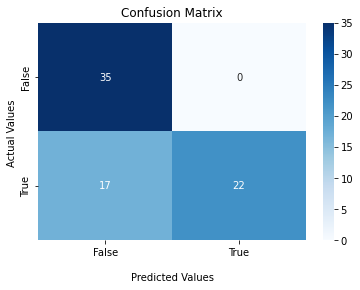

In [37]:
import seaborn as sns

ax = sns.heatmap(cm, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [38]:
y_pred_keras = model.predict(x_val).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_val, y_pred_keras)

In [39]:
auc_keras = auc(fpr_keras, tpr_keras)

In [40]:
auc_keras

0.9054945054945055

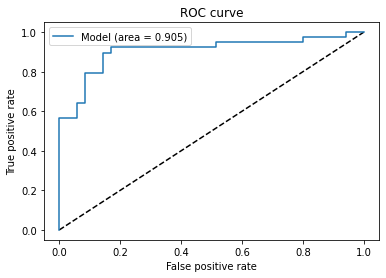

In [41]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Model (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### 2.3 Complex Highest performing Dense FNN neural network model from Mellema 2022 with modifications

In [42]:
def Dense_model(width=61, height=73, depth=61):
    """Build a complex Highest performing Dense FNN neural network model from Mellema 2022."""

    inputs = keras.Input((width, height, depth, 1))
    
    x = layers.Dense(units=128, activation="relu", kernel_regularizer = keras.regularizers.L2(0.00011))(inputs)
    
    x = layers.BatchNormalization()(x)
    
    x = layers.Dropout(0.18)(x)
    x = layers.Dense(units=128, activation="relu")(x)
    x = layers.Dropout(0.18)(x)
    x = layers.Dense(units=64, activation="relu")(x)
    x = layers.Dropout(0.18)(x)
    x = layers.Dense(units=42, activation="relu")(x)
    x = layers.Flatten()(x)
    
    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="DFNN_complex")
    return model


# Build model.
model = Dense_model(width=61, height=73, depth=61)
model.summary()

Model: "DFNN_complex"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 61, 73, 61, 1)]   0         
                                                                 
 dense_8 (Dense)             (None, 61, 73, 61, 128)   256       
                                                                 
 batch_normalization_1 (Batc  (None, 61, 73, 61, 128)  512       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 61, 73, 61, 128)   0         
                                                                 
 dense_9 (Dense)             (None, 61, 73, 61, 128)   16512     
                                                                 
 dropout_3 (Dropout)         (None, 61, 73, 61, 128)   0         
                                                      

In [43]:
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.96, staircase=True)

# Compile model.
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.AUC()],
)

# Define callbacks.
#checkpoint_cb = keras.callbacks.ModelCheckpoint(
 #   "3d_image_classification_Cxa_adamDFNN.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_binary_accuracy", patience=15)

# Train the model, doing validation at the end of each epoch
#epochs = 50
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    callbacks=[early_stopping_cb],
)

# # Train the model, doing validation at the end of each epoch
# epochs = 50
# model.fit(
#     train_dataset,
#     validation_data=validation_dataset,
#     epochs=epochs,
#     shuffle=True,
#     callbacks=[checkpoint_cb, early_stopping_cb],
# )

Epoch 1/125
39/39 [==============================] - 6s 124ms/step - loss: 19.0710 - binary_accuracy: 0.5577 - auc_2: 0.5834 - val_loss: 38.6919 - val_binary_accuracy: 0.6476 - val_auc_2: 0.6754
Epoch 2/125
39/39 [==============================] - 5s 118ms/step - loss: 4.0600 - binary_accuracy: 0.7115 - auc_2: 0.7423 - val_loss: 12.9072 - val_binary_accuracy: 0.6476 - val_auc_2: 0.6754
Epoch 3/125
39/39 [==============================] - 5s 119ms/step - loss: 3.0683 - binary_accuracy: 0.6891 - auc_2: 0.7225 - val_loss: 6.0854 - val_binary_accuracy: 0.5143 - val_auc_2: 0.6754
Epoch 4/125
39/39 [==============================] - 5s 118ms/step - loss: 1.8791 - binary_accuracy: 0.7724 - auc_2: 0.7953 - val_loss: 1.2474 - val_binary_accuracy: 0.8190 - val_auc_2: 0.8461
Epoch 5/125
39/39 [==============================] - 5s 118ms/step - loss: 1.7643 - binary_accuracy: 0.7564 - auc_2: 0.8162 - val_loss: 2.0051 - val_binary_accuracy: 0.7143 - val_auc_2: 0.8169
Epoch 6/125
39/39 [=============

In [44]:
#evaluate on the holdout data
model.evaluate(x_val, y_val)

3/3 [==============================] - 0s 77ms/step - loss: 0.6436 - binary_accuracy: 0.7027 - auc_2: 0.9007


[0.6436006426811218, 0.7027027010917664, 0.9007325768470764]

In [45]:
from sklearn.metrics import classification_report, confusion_matrix

preds = model.predict(x_val)

preds = np.where(preds > .5, 1,0)



print(classification_report(y_val, preds))
cm = confusion_matrix(y_val, preds)

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        35
           1       1.00      0.44      0.61        39

    accuracy                           0.70        74
   macro avg       0.81      0.72      0.68        74
weighted avg       0.82      0.70      0.68        74



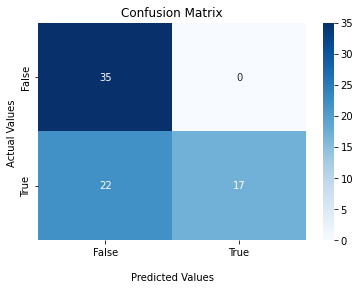

In [46]:
import seaborn as sns

ax = sns.heatmap(cm, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [47]:
y_pred_keras = model.predict(x_val).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_val, y_pred_keras)

In [48]:
auc_keras = auc(fpr_keras, tpr_keras)

In [49]:
auc_keras

0.904029304029304

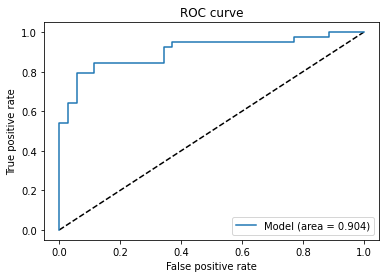

In [50]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Model (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [51]:
end = timer()
elapsed_time = end - start
print(elapsed_time )

220.62901122123003


In [52]:
# Append to file
file1 = open("testing_batch_size.txt", "a") #to overwrite, use "w"

#L = ["batch_size", "epochs", "elapsed_time"]
L = [str(batch_size), str(epochs), str(elapsed_time)]

file1.write("\n")

for element in L:
    file1.write(element + ",")

#file1.writelines(L) #I think this concatenates what's in L

file1.close() 

In [53]:
file1 = open("testing_batch_size.txt", "r")
print("Output of Readlines after appending")
print(file1.read())
print()
file1.close()

Output of Readlines after appending
batch_size,epochs,elapsed_time,
16,50,285.331844124943,
32,50,324.09506921097636,
8,50,264.6607833467424,
4,50,345.383199935779,
8,75,252.03459496237338,
8,100,195.35715249180794,
8,25,237.12536557391286,
8,150,238.06008644029498,
8,125,220.62901122123003,

